# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [92]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [93]:
num_classes = 10 
num_features = 784 

learning_rate = 1e-3
training_steps = 3000
batch_size = 256
display_step = 100 

n_hidden_1 = 128 
n_hidden_2 = 256 

In [94]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

x_train, x_test = x_train / 255., x_test / 255.

train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [95]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="weights")
        self.b = tf.Variable(tf.zeros([out_features]), name="biases")

    def __call__(self, x, activation = 0):
      y = tf.matmul(x, self.w) + self.b
      if activation != 0:
            return tf.nn.softmax(y)
      else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    self.layer_outputs = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):
    x1 = self.layer_1(x)
    x2 = self.layer_2(x1) 
    x3 = self.layer_outputs(x2, activation = 1)
    return x3

In [96]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)

    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

def accuracy(y_pred, y_true):
    accuracy = tf.metrics.Accuracy()
    accuracy.update_state(y_true, tf.argmax(y_pred, axis=1))
    return accuracy.result()

In [97]:
neural_net = NN(name="mnist")

def train(nn, input_x, output_y):
  optimizer = tf.optimizers.Adam(learning_rate)

  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
        
  trainable_variables = neural_net.trainable_variables

  gradients = g.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

In [98]:
loss_history = []  
accuracy_history = [] 

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
  train(neural_net, batch_x, batch_y)
    
  if step % display_step == 0:
    pred = neural_net(batch_x)

    loss = cross_entropy(pred, batch_y)
    acc = accuracy(pred, batch_y)

    accuracy_history.append(acc)
    loss_history.append(loss)

    print(f"Training epoch: {step}, Loss: {loss}, Accuracy: {acc}")

Training epoch: 0, Loss: 3081.06689453125, Accuracy: 0.078125
Training epoch: 100, Loss: 380.726318359375, Accuracy: 0.609375
Training epoch: 200, Loss: 204.45008850097656, Accuracy: 0.7734375
Training epoch: 300, Loss: 160.21340942382812, Accuracy: 0.828125
Training epoch: 400, Loss: 169.0873565673828, Accuracy: 0.828125
Training epoch: 500, Loss: 111.38075256347656, Accuracy: 0.8828125
Training epoch: 600, Loss: 109.74578094482422, Accuracy: 0.8515625
Training epoch: 700, Loss: 72.89405822753906, Accuracy: 0.9140625
Training epoch: 800, Loss: 108.98318481445312, Accuracy: 0.88671875
Training epoch: 900, Loss: 82.11788177490234, Accuracy: 0.8984375
Training epoch: 1000, Loss: 65.7462158203125, Accuracy: 0.921875
Training epoch: 1100, Loss: 92.91021728515625, Accuracy: 0.91796875
Training epoch: 1200, Loss: 48.216529846191406, Accuracy: 0.94140625
Training epoch: 1300, Loss: 72.01223754882812, Accuracy: 0.9375
Training epoch: 1400, Loss: 49.17584228515625, Accuracy: 0.95703125
Training

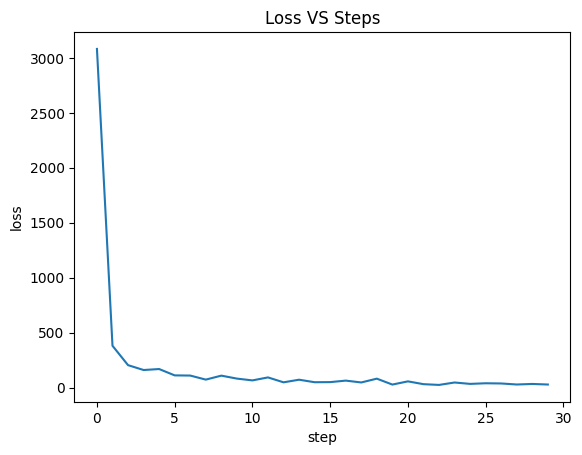

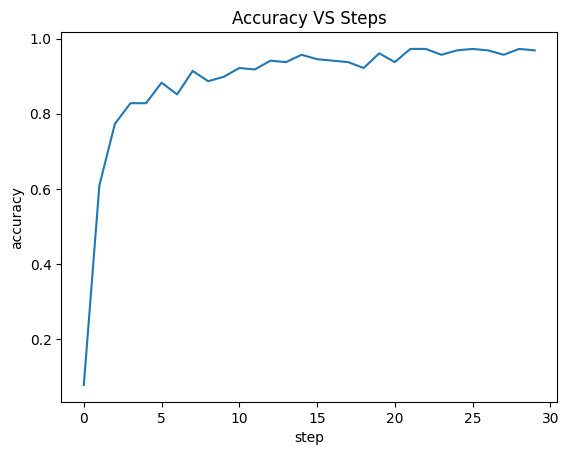

In [99]:
plt.figure()
plt.plot(loss_history)
plt.title('Loss VS Steps')
plt.ylabel('loss')
plt.xlabel('step')
plt.show()

plt.figure()
plt.plot(accuracy_history)
plt.title('Accuracy VS Steps')
plt.ylabel('accuracy')
plt.xlabel('step')
plt.show()

In [100]:
pred = neural_net(x_test)
print(f"Test Accuracy: {accuracy(pred, y_test)}")

Test Accuracy: 0.9315000176429749


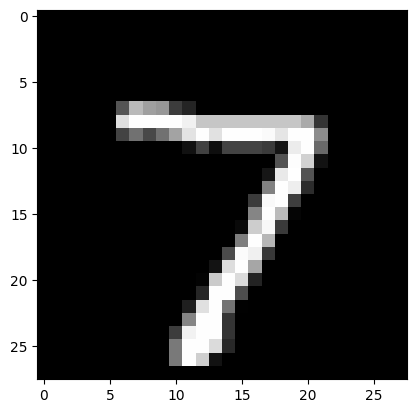

Model prediction: 7


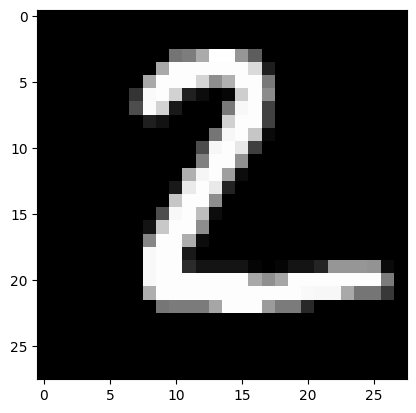

Model prediction: 2


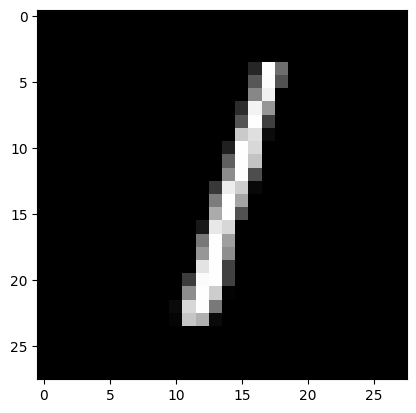

Model prediction: 1


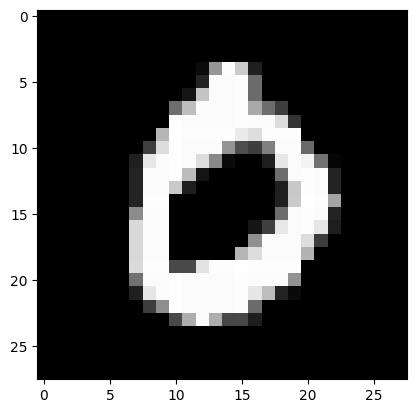

Model prediction: 0


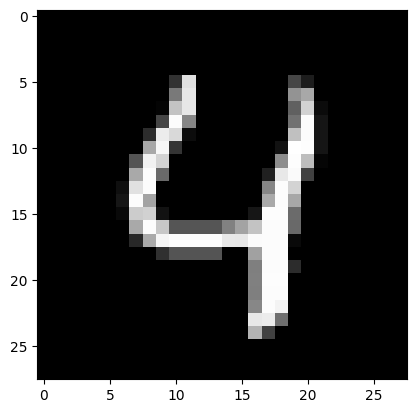

Model prediction: 4


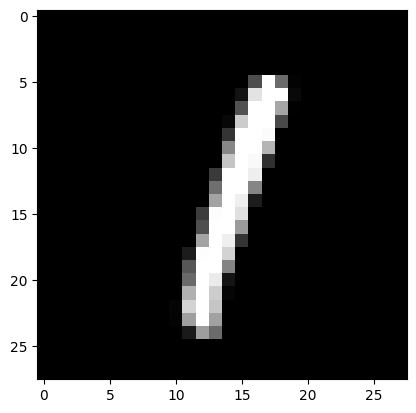

Model prediction: 1


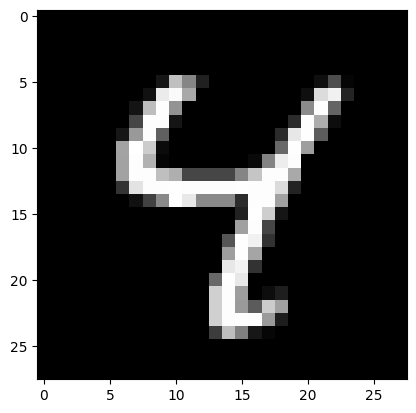

Model prediction: 4


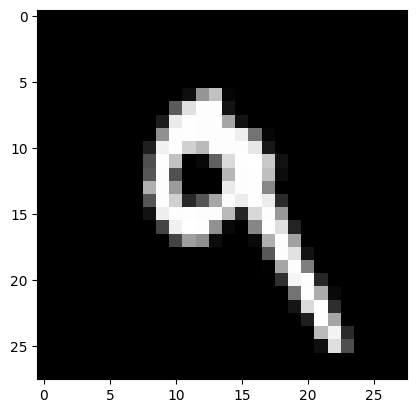

Model prediction: 9


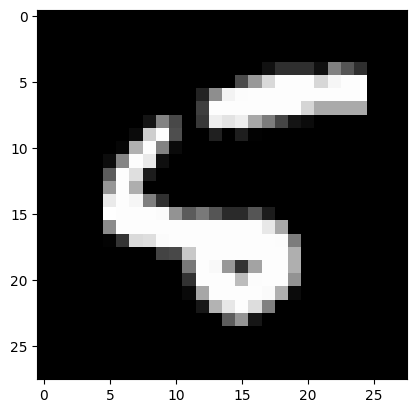

Model prediction: 6


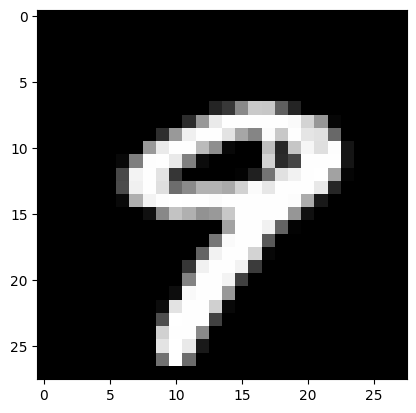

Model prediction: 9


In [101]:
n_images = 10
test_images = x_test[:n_images]
predictions = neural_net(test_images)

for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.show()
    print(f"Model prediction: {np.argmax(predictions.numpy()[i])}")

#### Висновок

Сьогодні ми створили нейронну мережу для класифікації зображень з mnist датасету. Отримана точність: 93%. Похибка може бути спричинена тим, що усі механізми були реалізовані з використанням низькорівневого API Tensorflow, оскільки використовуючи готові рішення з Keras точність вища. Однак, це непоганий результат зважаючи на те, що ми зробили невелику кількість ітерацій та мали невеликий набір даних.